In [1]:
%load_ext autoreload
%autoreload 2

# Make data by hand and get the analysis done quick!

In [2]:
import pandas as pd
import pathways_via_enrichr
import plotnine as p9

In [3]:
## PARAMETERS
alpha = 0.05
FDR_cutoff = 0.01
NCBI_IDs = pd.read_csv("NCBI_IDs.txt", sep="\t")

In [4]:
dframe_dea = pd.read_csv("input/2021-01-25/edgeR_A549_24hr-H1299_24hr.tsv", sep="\t")
dframe_dea["NCBIid"] = dframe_dea.GeneID.astype('str')
dframe_dea = dframe_dea.query(f"FDR < {FDR_cutoff}")
dframe_dea = pd.merge(dframe_dea, NCBI_IDs, how="left", on="NCBIid")
display(dframe_dea.head(),
        dframe_dea.shape)

,GeneID,logFC,logCPM,F,PValue,FDR,NCBIid,GeneSymbol
0,216,16.912293,12.536198,2426.394884,8.635426e-43,2.452029e-38,216,ALDH1A1
1,57016,16.618520,12.242508,2266.587871,4.297239e-42,6.101005e-38,57016,AKR1B10
2,4103,-14.549342,10.174876,1349.000965,8.021548e-37,7.019911e-33,4103,MAGEA4
3,3487,14.510950,10.136426,1336.892877,9.888940e-37,7.019911e-33,3487,IGFBP4
4,218,14.399239,10.024878,1280.744769,2.674878e-36,1.440274e-32,218,ALDH3A1


(1251, 8)

In [5]:
EXTERNAL_DE = "input/2021-01-25/GSE108605/resultset_ID486388.data.txt"

dframe_extde = pd.read_table(EXTERNAL_DE, comment="#")

dframe_extde['NCBIid'] = dframe_extde['NCBI_ID']
pvalue_exp  = dframe_extde.columns[-2]
dframe_extde = dframe_extde #.query(f"{pvalue_exp} < {alpha}")
dframe_extde


display(dframe_extde.head(),
        dframe_extde.shape)

,Element_Name,Gene_Symbol,Gene_Name,NCBI_ID,FoldChange_camptothecin,Tstat_camptothecin,PValue_camptothecin,NCBIid
0,A_23_P103588,HMGCS2,3-hydroxy-3-methylglutaryl-CoA synthase 2,3158,-0.1391,-0.4118,0.691300,3158
1,A_23_P108492,MARS2,"methionyl-tRNA synthetase 2, mitochondrial",92935,0.6040,10.0100,0.000008,92935
2,A_23_P101208,CYB5A,cytochrome b5 type A,1528,0.1336,1.7150,0.124700,1528
3,A_23_P102109,TUBA4A|TUBA4B,tubulin alpha 4a|tubulin alpha 4b,7277|80086,1.0880,4.8850,0.001217,7277|80086
4,A_23_P107322,CORO6,coronin 6,84940,0.3043,1.2970,0.230700,84940


(430, 8)

In [6]:
# Main DE EnrichR
gene_list_main = dframe_dea["GeneSymbol"].astype('str').tolist()

## EXTERNAL DE EnrichR
obj = pathways_via_enrichr.CallEnrichr(gene_list_main)
main_enrichr = pathways_via_enrichr.get_geneset_dataframe(obj)

In [8]:
gene_list_ext = dframe_extde.copy()
gene_list_ext["GeneList"] = gene_list_ext["Gene_Symbol"].apply(lambda x : str(x).split("|")) 
gene_list_ext = gene_list_ext.explode("GeneList")


## EXTERNAL DE EnrichR
obj = pathways_via_enrichr.CallEnrichr(gene_list_ext["GeneList"].tolist())
external_enrichr = pathways_via_enrichr.get_geneset_dataframe(obj)

main_enrichr

In [9]:
## Combine data

dframe_mca =\
    pd.concat(
        [
            main_enrichr[["Gene_set", "Term"]].assign(Experiment = "A549_v_H1299"),
            external_enrichr[["Gene_set", "Term"]].assign(Experiment = "camptothecin")
        ]
    )

dframe_mca

,Gene_set,Term,Experiment
0,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,NFE2L2 CHEA,A549_v_H1299
1,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,KLF4 CHEA,A549_v_H1299
2,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,SOX2 CHEA,A549_v_H1299
3,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,PPARD CHEA,A549_v_H1299
4,ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X,HNF4A ENCODE,A549_v_H1299
...,...,...,...
6,GO_Biological_Process_2018,positive regulation of establishment of protei...,camptothecin
7,GO_Biological_Process_2018,3'-phosphoadenosine 5'-phosphosulfate metaboli...,camptothecin
0,GO_Cellular_Component_2018,chaperonin-containing T-complex (GO:0005832),camptothecin
0,GO_Molecular_Function_2018,aryl sulfotransferase activity (GO:0004062),camptothecin


In [10]:
dframe_mca.to_csv("output/2021-01-25/mvp-mca.tsv", sep="\t", index=False)

In [12]:
import corresponder
import utils
import plotnine as p9

MCA_ANALYSIS_OBJ = utils.calculate_mca(dframe_mca)
dframe_coords = utils.mca_to_coordinates(dframe_mca,
                                         MCA_ANALYSIS_OBJ
)
display(dframe_coords.shape,
        dframe_coords.head(),
       dframe_coords.tail())

(9554, 5)

,Factor,x,y,AssociationType,Value
0,Gene_set_ChEA_2016,-2.598850,2.362639,Gene,set_ChEA_2016
1,Gene_set_DSigDB,-0.891342,-0.561396,Gene,set_DSigDB
2,Gene_set_DrugMatrix,0.085322,-0.016754,Gene,set_DrugMatrix
3,Gene_set_ENCODE_TF_ChIP-seq_2015,2.695160,0.782342,Gene,set_ENCODE_TF_ChIP-seq_2015
4,Gene_set_ENCODE_and_ChEA_Consensus_TFs_from_Ch...,-0.544458,2.989044,Gene,set_ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X


,Factor,x,y,AssociationType,Value
9549,Term_znf217 22593193 mda mb 231 gof human gpl5...,2.861577,0.186907,Term,znf217 22593193 mda mb 231 gof human gpl570 gs...
9550,Term_znf263 19887448 helas3 lof human gpl6884 ...,2.964337,0.002180,Term,znf263 19887448 helas3 lof human gpl6884 gse19...
9551,Term_zymogen activation (GO:0031638),0.461265,1.548093,Term,zymogen activation (GO:0031638)
9552,Experiment_A549_v_H1299,0.003112,-0.011315,Experiment,A549_v_H1299
9553,Experiment_camptothecin,-2.281855,8.295393,Experiment,camptothecin


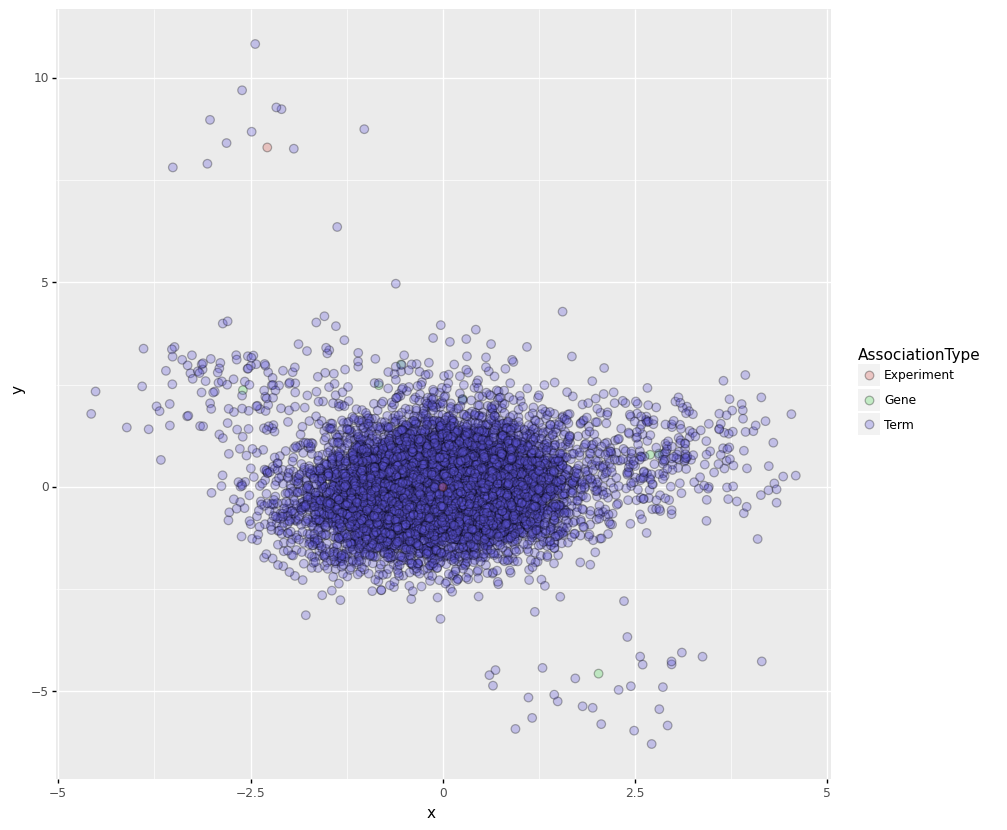

<ggplot: (8783730108832)>

In [13]:
p9.options.figure_size = 10,10
gg = (p9.ggplot(dframe_coords) +
    p9.aes(x='x', y='y',
           fill="AssociationType") +
           p9.geom_jitter(alpha = 0.3,
                          size=3) #+ p9.scale_shape_manual(['v','H', '^'])
    )
display(gg)

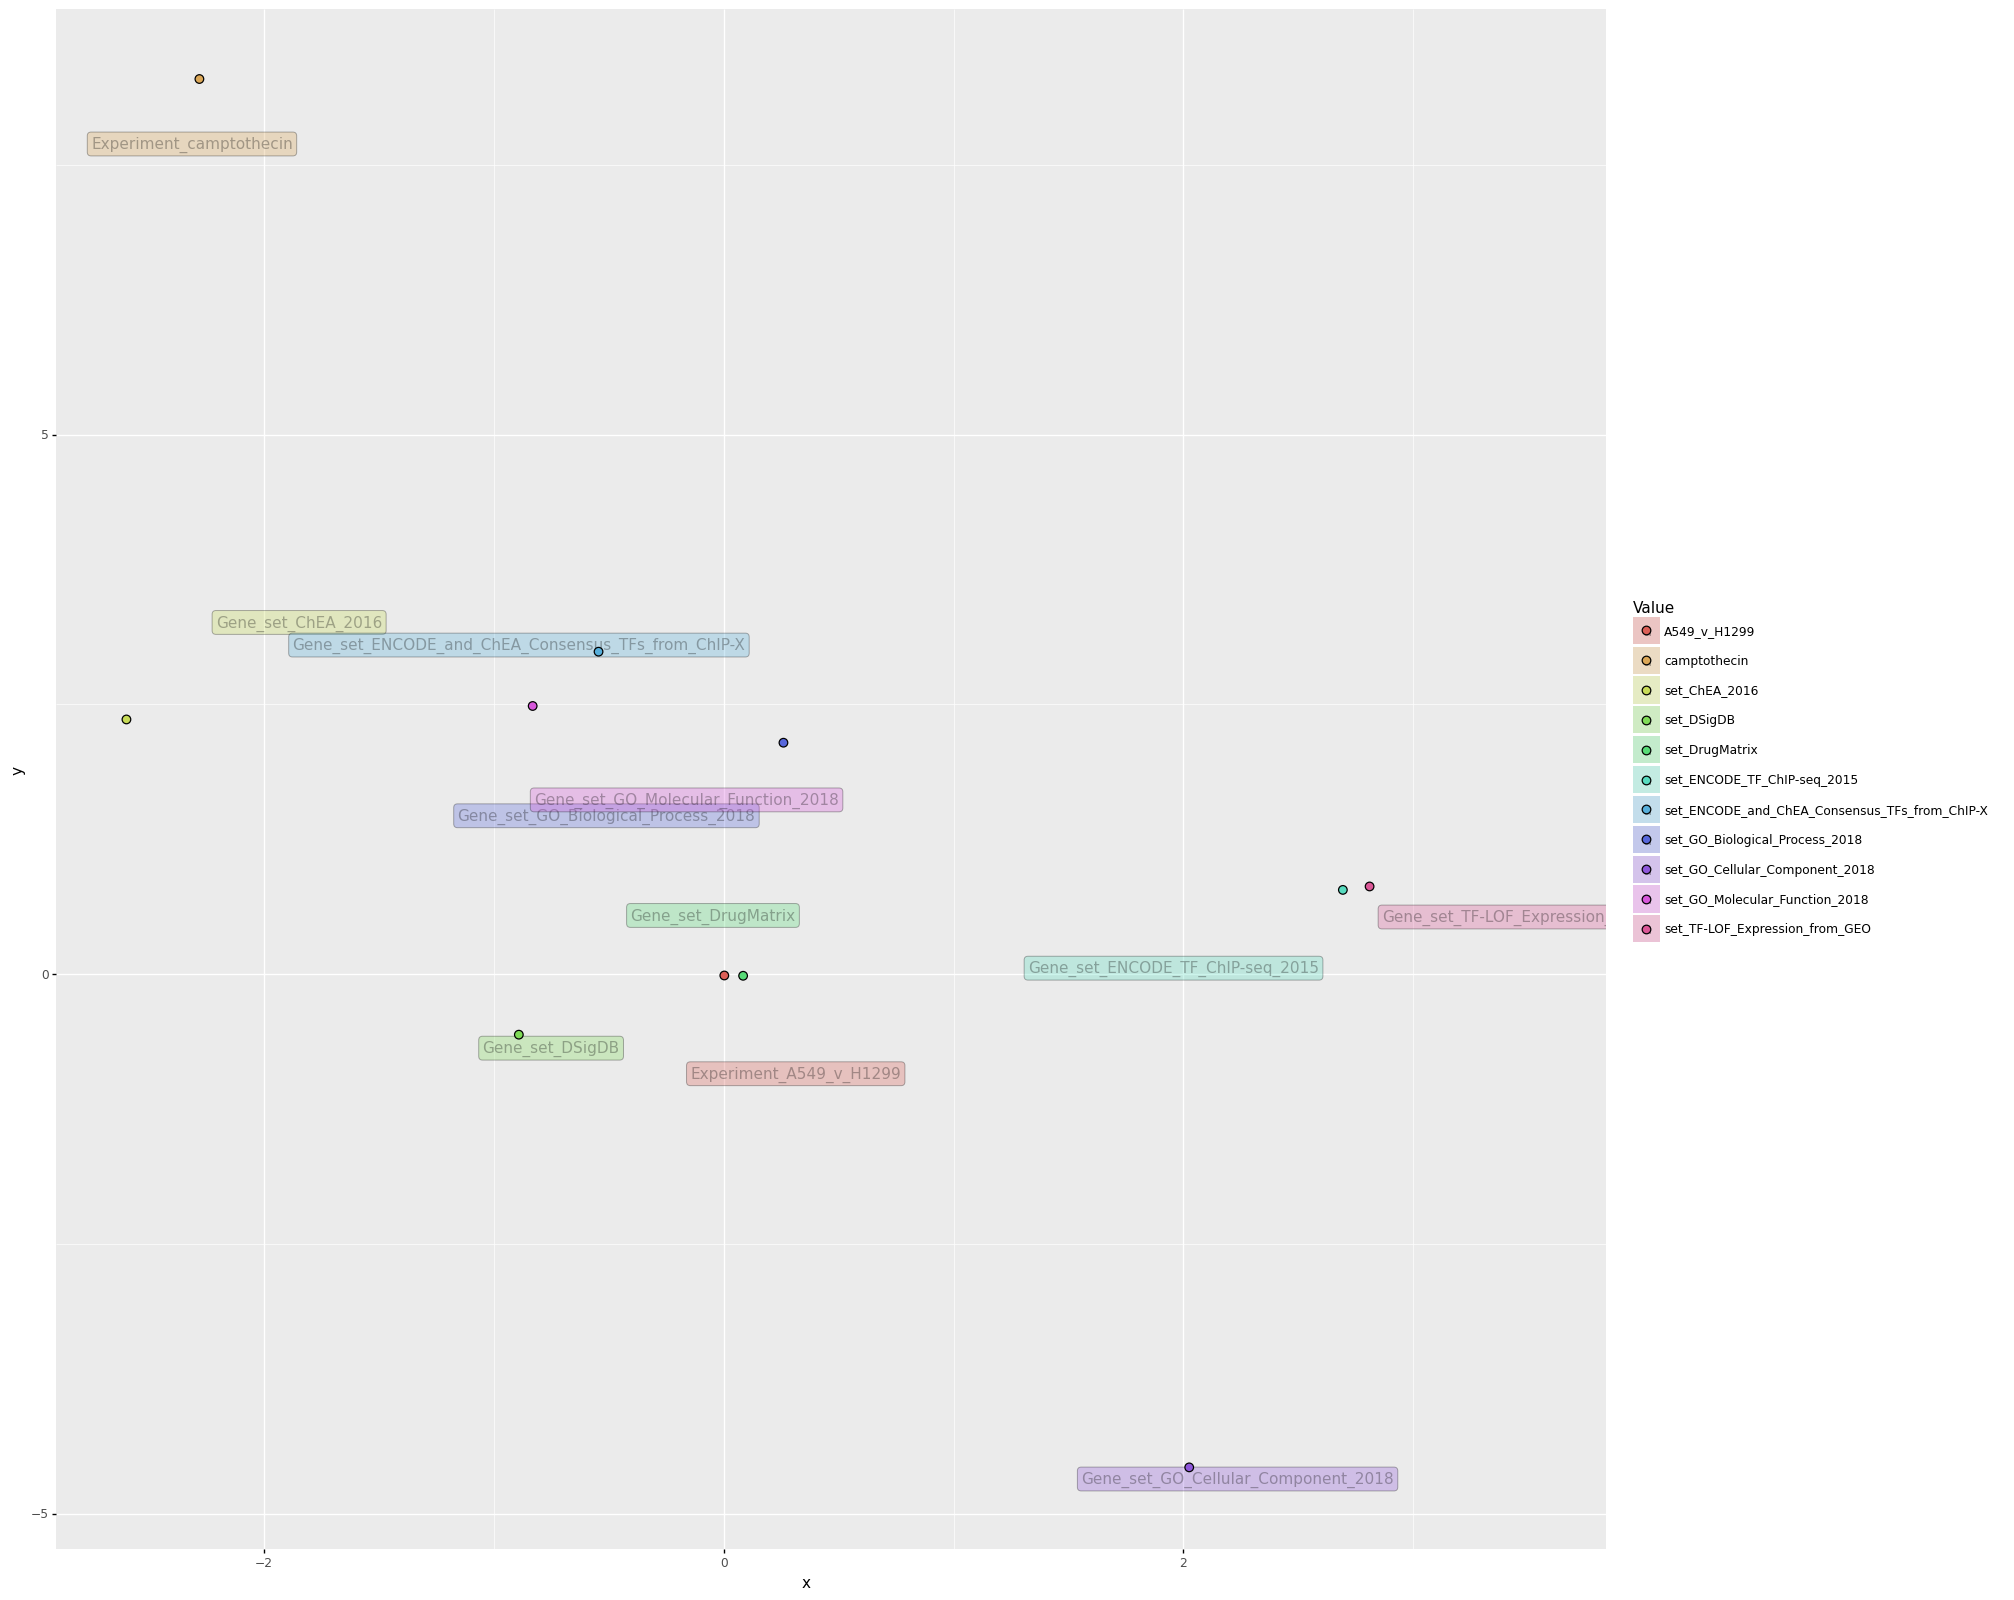

<ggplot: (8783729427481)>

In [14]:
p9.options.figure_size = 20,20
import random

data = dframe_coords.query("AssociationType != 'Term'")
coordlen = len(data)

gg = (p9.ggplot(data) +
    p9.aes(x='x', y='y',
           fill="Value",
           label = "Factor"
          ) +
    p9.geom_label(alpha = 0.3,
                  nudge_x=[(random.random() -0.5) * 2 for _ in range(coordlen)],
                  nudge_y=[(random.random() -0.5) * 2 for _ in range(coordlen)]) +  
    p9.geom_jitter(size=3) #+ p9.scale_shape_manual(['v','H', '^'])
    )
display(gg)

In [15]:
dframe_coords.to_excel("output/MVP_MCA_results.xlsx")